# DARLIN application (Fig 5): cell migration

Here, given the output from snakemake_DARLIN, which converts fastq files to individual alleles associated with each UMI/cell, we analyze the lineage relationship between different cell types and/or bones.

You need to install mosaiclineage for running this pipeline: https://github.com/ShouWenWang-Lab/MosaicLineage

In [19]:
import cospar as cs
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import mosaiclineage as mosaic
import mosaiclineage.help_functions as hf
import mosaiclineage.plot_scripts as mosaic_pl
import mosaiclineage.DARLIN as mosaic_dar
import warnings
warnings.filterwarnings("ignore")

## setting cospar
cs.logging.print_version()
cs.settings.verbosity=0
cs.settings.set_figure_params(format='pdf',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=2)
    
%matplotlib inline

## notebook specific parameters
target_sample='20221017_tissue_LL829_LL839'
read_cutoff=3 # Read cutoff: each UMI must be covered by at least 3 reads
min_clone_size=2 # Clone size cutoff: only clones with at least 2 UMI will be used in downstream analysis
max_rep_N=0 # Mouse replicate number cutoff: this allele can appear in less than max_rep_N mouse samples in our allele bank (0 means de novo alleles)
frequency_cutoff=0.1 # Allele probability cutoff: the allele generation probability must be lower than this value （this parameter is overrided by max_rep_N=0）
BC_complexity=4 # The barcode structure complexity (mutation event number + inserted base pairs) cutoff: must be >=4.  
norm_method='' # choices: '', '_CloneNumNorm', '_CloneSizeCutOff
save_data_des=f'_freqCutoff{frequency_cutoff}{norm_method}'

## setup folders 
root_path='../DATA'
ref_dir=mosaic.settings.ref_dir
root_analysis_path='DARLIN_Fig5'
data_path_1=os.path.join(root_path,target_sample,'CARLIN',f'results_cutoff_override_{read_cutoff}')
  
if os.path.exists(root_path):
    data_analysis_path=os.path.join(root_analysis_path,'data')   
    paper_figure_path=os.path.join(root_analysis_path,'figure')    
    os.makedirs(data_analysis_path,exist_ok=True)
    os.makedirs(paper_figure_path,exist_ok=True)
    cs.settings.data_path=data_analysis_path
    cs.settings.figure_path=paper_figure_path

Running cospar 0.3.3 (python 3.8.18) on 2023-10-09 21:35.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


## Functions

In [2]:
def apply_frequency_and_complexity_cutoff_to_get_HQ_alleles(df_merge,BC_complexity,frequency_cutoff):
    df_sc_CARLIN=hf.generate_sc_CARLIN_from_CARLIN_output(df_merge)
    df_sc_CARLIN['mutation_N']=df_sc_CARLIN['allele'].apply(lambda x: len(x.split(',')))
    df_sc_CARLIN['allele']=df_sc_CARLIN['allele'].apply(lambda x: x[6:]) # exclude 'locus_' at the front of the allele. This is designed only for data with a single locus
    ins_per_allele, del_per_allele=hf.mutations_length_per_allele_ins_del(df_sc_CARLIN)
    cumu_ins_length=[np.sum(x) for x in ins_per_allele]
    df_sc_CARLIN['insertion_length']=cumu_ins_length
    df_sc_CARLIN_HQ_raw=mosaic_dar.filter_high_quality_single_alleles(df_sc_CARLIN,normalized_count_cutoff=frequency_cutoff,sample_count_cutoff=max_rep_N)
    df_sc_CARLIN_HQ=df_sc_CARLIN_HQ_raw[(df_sc_CARLIN_HQ_raw['mutation_N']+df_sc_CARLIN_HQ_raw['insertion_length'])>=BC_complexity]
    
    if norm_method=='':
        return df_sc_CARLIN_HQ
    elif norm_method=='_CloneNumNorm':
        df_sc_CARLIN_HQ_balanced=balance_clone_number(df_sc_CARLIN_HQ)
        return df_sc_CARLIN_HQ_balanced
    elif norm_method=='_CloneSizeCutOff':
        df_tmp=df_sc_CARLIN_HQ.groupby('allele').agg(count=('RNA_id',lambda x: len(set(x))))
        fig,ax=plt.subplots(figsize=(4,3.5))
        sns.histplot(df_tmp['count'],log_scale=True)
        plt.yscale('log')

        sel_index=df_sc_CARLIN_HQ['allele'].isin(df_tmp[df_tmp['count']<=1000].index)
        print(f'sel fraction with <=1000 UMIs: {np.mean(sel_index)}')

        df_sc_CARLIN_HQ_balanced=balance_clone_number(df_sc_CARLIN_HQ[sel_index])
        return df_sc_CARLIN_HQ_balanced

def balance_clone_number(df_sc_CARLIN_HQ):
    """
    Balance clone number across bones by sub-sampling alleles.
    This is not used in the end.
    """
    df_sc_CARLIN_HQ['cell_type']=df_sc_CARLIN_HQ['sample'].apply(lambda x:x.split('-')[-1])
    df_sc_CARLIN_HQ['bone']=df_sc_CARLIN_HQ['sample'].apply(lambda x:x.split('-')[1])
    df_sc_CARLIN_HQ_tmp=df_sc_CARLIN_HQ[df_sc_CARLIN_HQ['bone']!='SK']
    df_clone_count=df_sc_CARLIN_HQ_tmp.groupby(['sample','cell_type']).agg({'allele':lambda x: len(set(x))}).reset_index()

    df_expected_count=df_clone_count.groupby('cell_type').agg('min').reset_index()
    cell_type_clone_N_map=dict(zip(df_expected_count['cell_type'],df_expected_count['allele']))
    print(cell_type_clone_N_map)

    df_sample_sub_list=[]
    for sel_sample in df_sc_CARLIN_HQ['sample'].unique():
        df_sample=df_sc_CARLIN_HQ[df_sc_CARLIN_HQ['sample']==sel_sample]
        all_alleles=list(df_sample['allele'].unique())


        if 'SK' not in sel_sample:
            import random
            sel_allele_N=cell_type_clone_N_map[sel_sample.split('-')[-1]]
            sel_alleles=random.sample(all_alleles,sel_allele_N)
            df_sample_sub=df_sample[df_sample['allele'].isin(sel_alleles)]
            df_sample_sub_list.append(df_sample_sub)
        else:
            df_sample_sub_list.append(df_sample)

    df_sc_CARLIN_HQ_balanced=pd.concat(df_sample_sub_list,ignore_index=True)
    return df_sc_CARLIN_HQ_balanced

def pvalue_estimation(df_tmp,key_1,key_2):
    from scipy.stats import ttest_ind
    var_list=list(df_tmp[key_1].unique())
    name_list=[]
    pvalue_list=[]
    for i in range(len(var_list)):
        for j in range(i+1,len(var_list)):
            test_data_0=df_tmp[df_tmp[key_1]==var_list[i]][key_2].values
            test_data_1=df_tmp[df_tmp[key_1]==var_list[j]][key_2].values
            stat,pvalue=ttest_ind(test_data_0,test_data_1)
            name_list.append((var_list[i],var_list[j]))
            pvalue_list.append(pvalue)
            
    return pd.DataFrame({'name':name_list,'pvalue':pvalue_list})

## rename files
new_LF='LL'
new_RF='RL'
new_SC='SP'
def rename_LF(x):
    if '-LF-' in x:
        x=f'-{new_LF}-'.join(x.split('-LF-'))
    if '-RF-' in x:
        x=f'-{new_RF}-'.join(x.split('-RF-'))
    if '-SC-' in x:
        x=f'-{new_SC}-'.join(x.split('-SC-'))
    return x

## Config parameters

In [3]:
mouse_list=['LL829','LL839','LL784'] 
stage_order=['E17','Neonate','Adult'] 

map_mouse_to_SampleList={'LL829':'no_skull','LL839':'with_skull','LL784':'with_skull'}
stage_map_new={'E17':'E17-1','Neonate':'Neonate-1','Adult':'Adult-1'}
mouse_map={'LL829':'Neonate','LL839':'E17','LL784':'Adult'}
mouse_map_2={'LL829':'Induce at neonate','LL839':'Induce at E17','LL784':'Induce at adult (8 weeks)'}
tissue_colors=dict(zip([new_LF,new_RF,new_SC,'SK','LA','RA'],list(sns.color_palette().as_hex())[:6]))  
celltype_colors={'HSC':'#66c2a5','MPP':'#fc8d62','MkP':'#8da0cb','MyP':'#e78ac3'}

ylim_map={'LL829':400,'LL839':2000,'LL784':1000} # max clone number
title_map={'Adult':'Induce at adult', 'E17':'Induce at E17', 'Neonate':'Induce at neonate'}
stage_id_map=dict(zip(stage_order,np.arange(len(stage_order))))

SampleList_RAW_0=[]
for mouse in mouse_list:
    for tissue in ['LL','RL','SK','SP']:
        for celltype in ['HSC','MPP','MkP','MyP']:
            SampleList_RAW_0.append(f'{mouse}-{tissue}-{celltype}')
            
SampleList_RAW_noSkull_0=[]
for mouse in mouse_list:
    for tissue in ['LL','RL','SP']:
        for celltype in ['HSC','MPP','MkP','MyP']:
            SampleList_RAW_noSkull_0.append(f'{mouse}-{tissue}-{celltype}')

# Analyze all samples and save processed data

## Preprocessing

In [4]:
# Take TC locus as an example. 
# Merge all results (LL784, LL829 and LL839) from Darlin analysis

locus='TC'
df_ref=pd.read_csv(f'{ref_dir}/reference_merged_alleles_{locus}.csv')
df_ref['invalid_alleles']=(df_ref['normalized_count']>=frequency_cutoff)  | (df_ref['sample_count']>max_rep_N)

for read_cutoff_tmp in [3]: # read cutoff
    for mouse in mouse_list:
        print(mouse) 
        data_path_tmp=os.path.join(root_path,target_sample,'CARLIN',f'results_cutoff_override_{read_cutoff_tmp}')
        merge_all_path=f'{data_path_tmp}/merge_all' 
        os.makedirs(merge_all_path,exist_ok=True) 
        if map_mouse_to_SampleList[mouse]=='with_skull':
            SampleList_RAW=[x for x in sorted(SampleList_RAW_0) if mouse in x]
        else:
            SampleList_RAW=[x for x in sorted(SampleList_RAW_noSkull_0) if mouse in x]

        short_names=[mouse_map[x[:5]]+'-'+x[6:] for x in hf.extract_first_sample_from_a_nesting_list(SampleList_RAW)]

        cs.settings.set_figure_params(figsize=(6,5.5))
        adata_TC, df_all_TC=mosaic_pl.analyze_cell_coupling(
            data_path_1,
            SampleList_RAW,
            df_ref,
            source=None,
            short_names=short_names,
            plot_restricted=False,
            min_clone_size=min_clone_size,
            clone_id_key='allele',
            plot_sample_number=False,
            plot_barcodes_binary=False,
            plot_barcodes_normalize=False,
            plot_cell_count=False,
            plot_hierarchy=False,
            plot_Jaccard=False,
            plot_pie=False,
            plot_correlation=False,
        )
        adata_TC.write_h5ad(f'{data_path_tmp}/merge_all/sample_by_allele_adata_{mouse}_{save_data_des}.h5ad')
        df_all_TC.to_csv(f'{data_path_tmp}/merge_all/df_allele_all_{mouse}_{save_data_des}.csv',index=0)

LL829
Apply minimum clone size 2
cell number sample_info.csv does not exist or ignore cell number information. Do not perform cell number correction for the obs_UMI_count
Clone number (before correction): 1945
Cell number (before correction): 3476
Clone number (after correction): 991
Cell number (after correction): 1877


100%|██████████████████████████████████████████████████████████████| 63308/63308 [00:00<00:00, 575314.59it/s]


LL839
Apply minimum clone size 2
cell number sample_info.csv does not exist or ignore cell number information. Do not perform cell number correction for the obs_UMI_count
Clone number (before correction): 9876
Cell number (before correction): 18103
Clone number (after correction): 5572
Cell number (after correction): 9721


100%|████████████████████████████████████████████████████████████| 111098/111098 [00:00<00:00, 758306.83it/s]


LL784
Apply minimum clone size 2
cell number sample_info.csv does not exist or ignore cell number information. Do not perform cell number correction for the obs_UMI_count
Clone number (before correction): 6093
Cell number (before correction): 11067
Clone number (after correction): 3597
Cell number (after correction): 5795


100%|██████████████████████████████████████████████████████████████| 95143/95143 [00:00<00:00, 777267.90it/s]


In [5]:
# To be re-run with all parameters

for mouse in mouse_list:
    for BC_complexity_tmp in [2,4,6]:
        print(mouse)
        df_merge=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}.csv')
        df_merge['sample']=df_merge['sample'].apply(rename_LF)
        df_sc_CARLIN_HQ=apply_frequency_and_complexity_cutoff_to_get_HQ_alleles(df_merge,BC_complexity_tmp,frequency_cutoff)
        df_sc_CARLIN_HQ.to_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity_tmp}_freq{frequency_cutoff}.csv',index=0)

LL829
LL829
LL829
LL839
LL839
LL839
LL784
LL784
LL784


# Downstream analysis

## Allele count per sample statistics

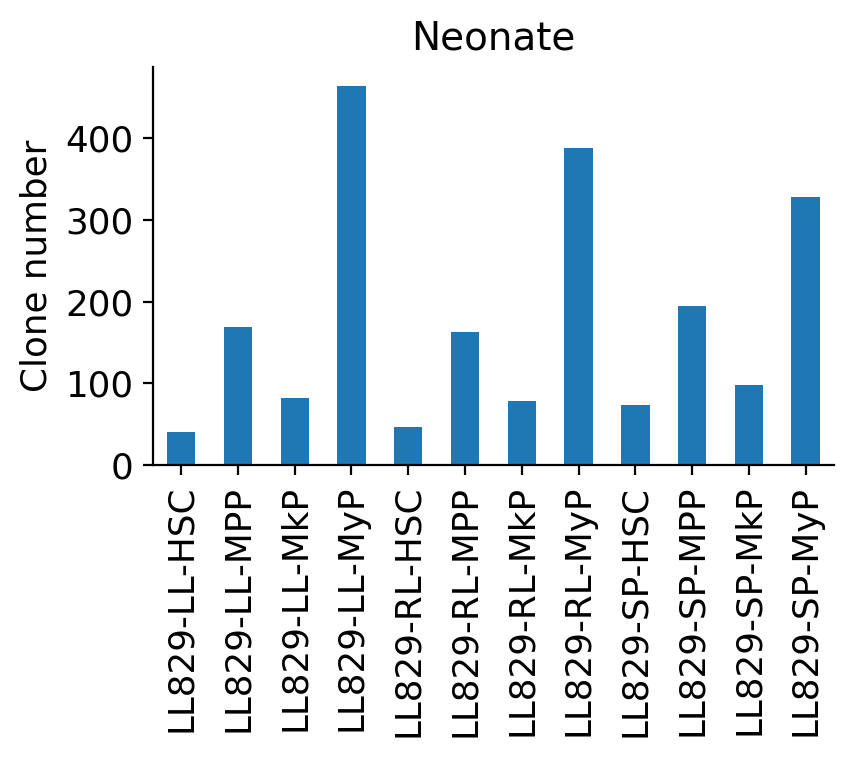

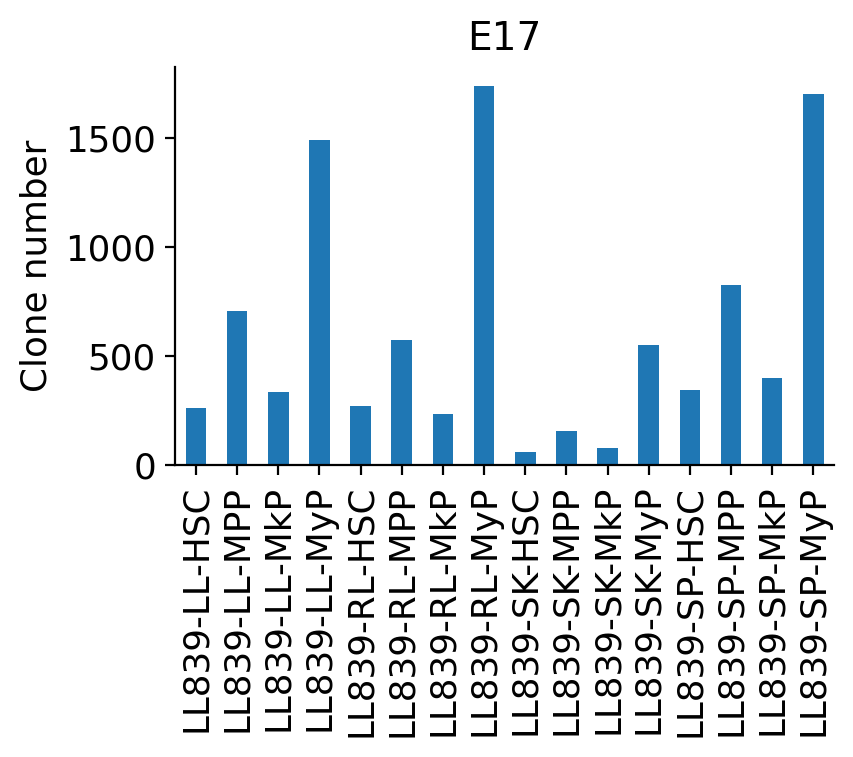

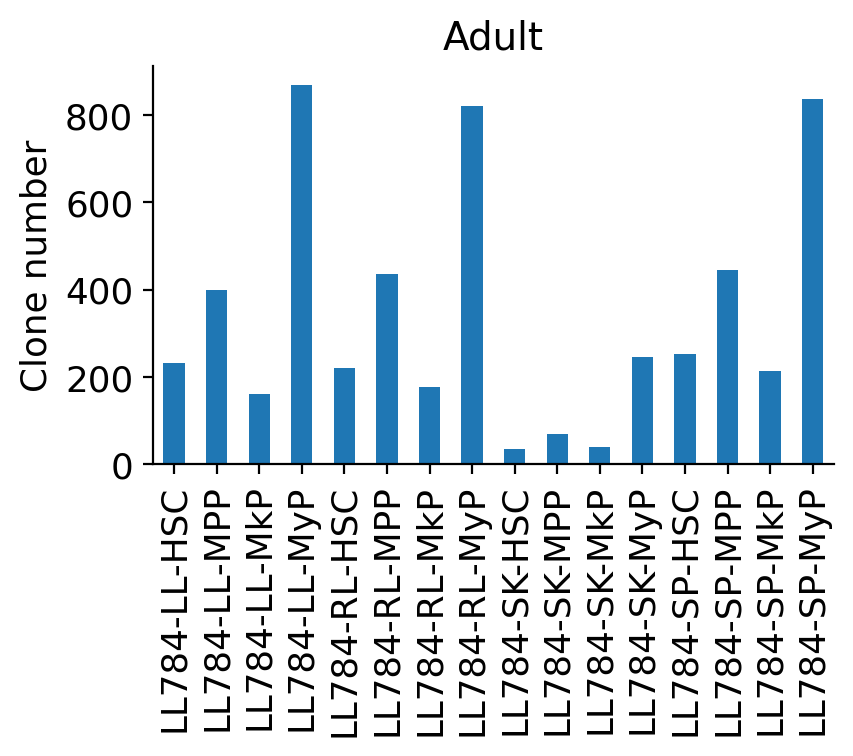

In [6]:
for mouse in mouse_list:    
    df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity}_freq{frequency_cutoff}.csv')
    fig,ax=plt.subplots(figsize=(4.5,4))
    df_sc_CARLIN_HQ.groupby('sample').agg({'allele':lambda x: len(set(x))}).plot(kind='bar',ax=ax)
    plt.xlabel('')
    plt.ylabel('Clone number')
    ax.get_legend().remove()
    plt.title(mouse_map[mouse])
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/clone_number_{mouse}.pdf')

## UMI count per allele statistics

------LL829-----
mean: 42.95206489675516
median: 3.0
------LL839-----
mean: 11.921658986175116
median: 3.0
------LL784-----
mean: 17.28988080142024
median: 5.0


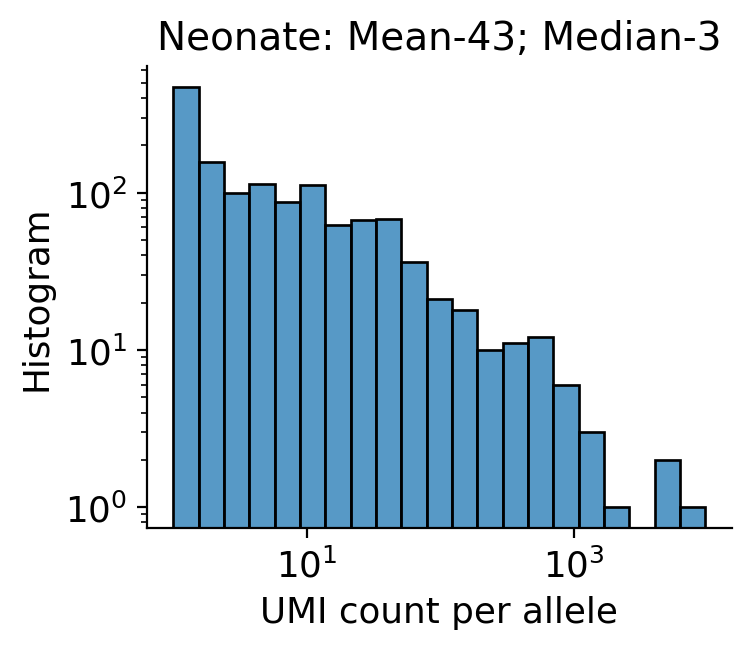

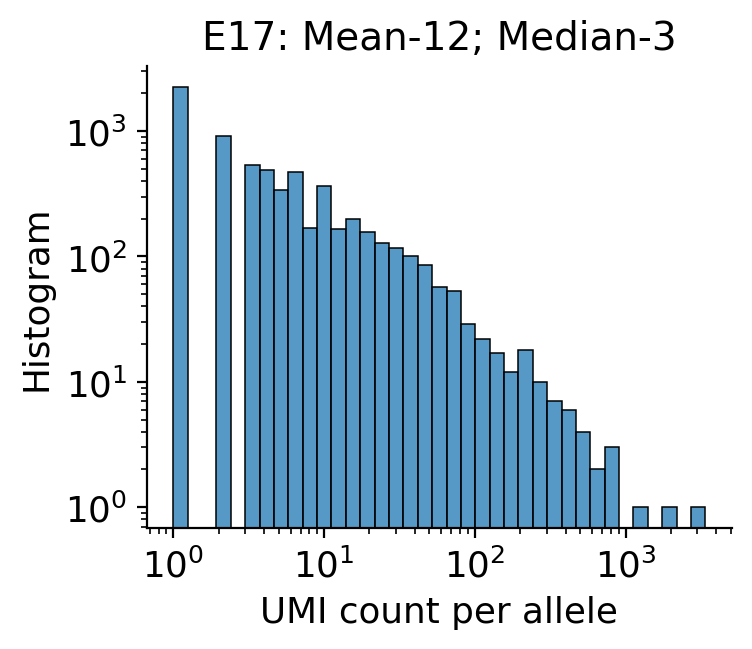

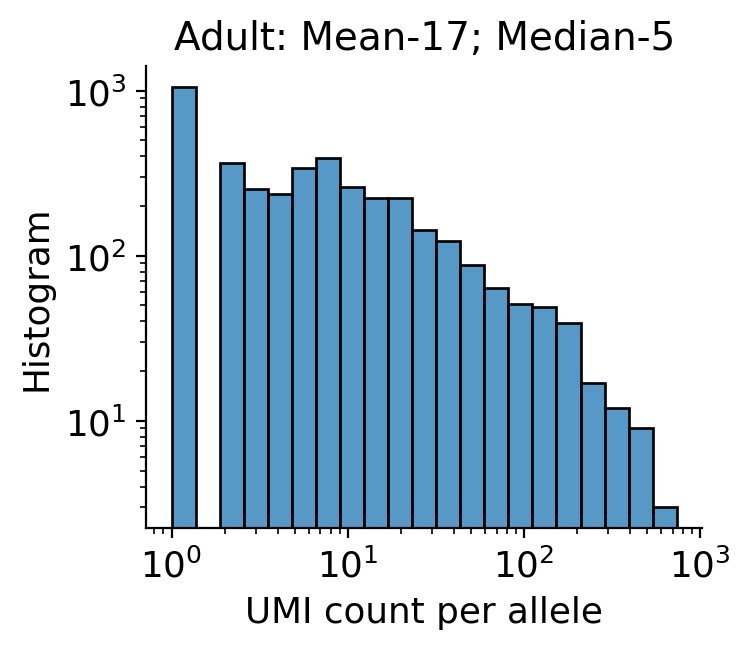

In [7]:
for mouse in mouse_list:
    print(f'------{mouse}-----')
    
    df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity}_freq{frequency_cutoff}.csv')
    
    fig,ax=plt.subplots(figsize=(4,3.5))
    df_plot=df_sc_CARLIN_HQ.groupby('allele').agg(count=('RNA_id',lambda x: len(set(x))))
    sns.histplot(data=df_plot,x='count',log_scale=True)
    plt.yscale('log')
    X_mean=df_plot['count'].mean()
    X_median=df_plot['count'].median()
    plt.title(f'{mouse_map[mouse]}: Mean-{X_mean:.0f}; Median-{X_median:.0f}')
    plt.xlabel('UMI count per allele')
    plt.ylabel('Histogram')
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/clone_size_distribution_{mouse_map[mouse]}')

    print('mean:', df_plot['count'].mean())
    print('median:', df_plot['count'].median())

## Clonal coupling score between different cell-types and/or bones

100%|██████████████████████████████████████████████████████████████| 68174/68174 [00:00<00:00, 823545.71it/s]


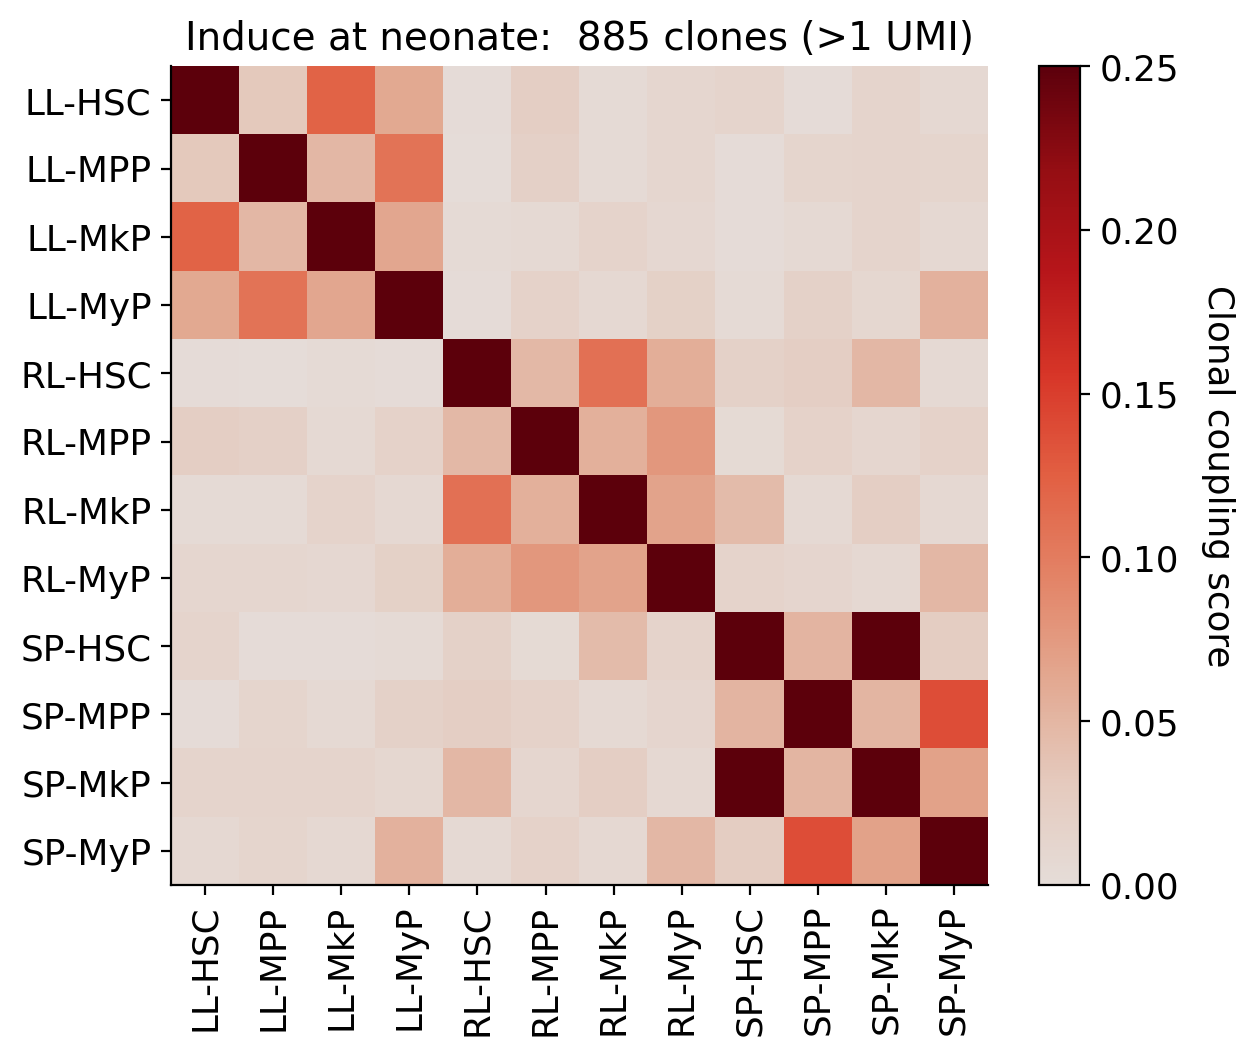

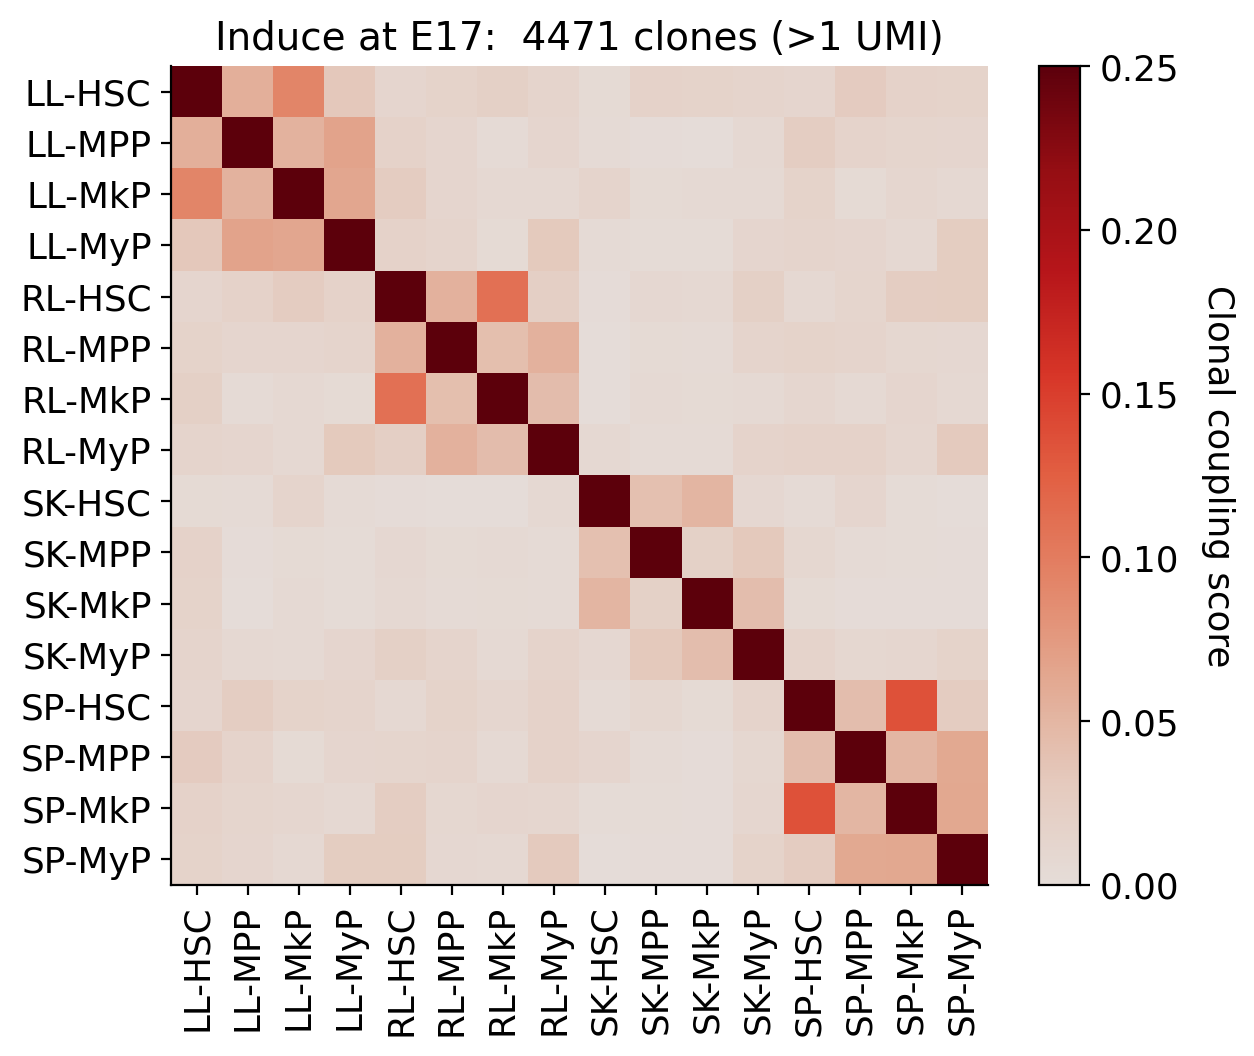

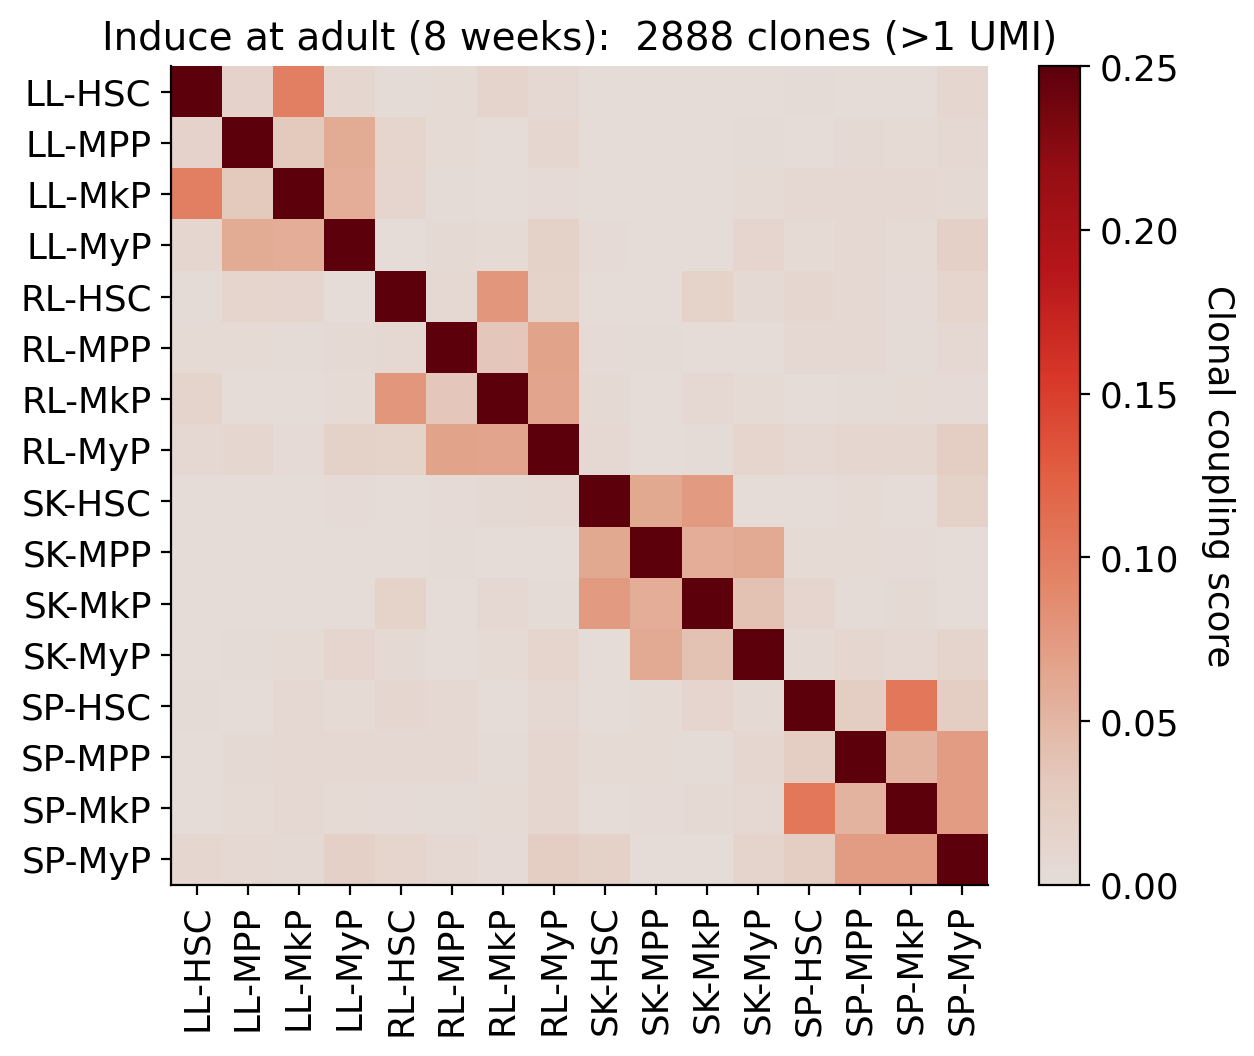

In [8]:
# Choose the parameters in mosaic_pl.analyze_cell_coupling_core to plot the figures you want

for mouse in mouse_list:    
    if map_mouse_to_SampleList[mouse]=='with_skull':
        SampleList_RAW=[rename_LF(x).split('_')[0] for x in SampleList_RAW_0 if mouse in x]
    else:
        SampleList_RAW=[rename_LF(x).split('_')[0] for x in SampleList_RAW_noSkull_0 if mouse in x]

    short_names=[x[6:] for x in hf.extract_first_sample_from_a_nesting_list(SampleList_RAW)]
    df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity}_freq{frequency_cutoff}.csv')
    adata_orig = hf.generate_adata_cell_by_allele(df_sc_CARLIN_HQ, min_clone_size=min_clone_size,clone_id_key='allele')    
    cs.settings.set_figure_params(figsize=(6,5.5))
 
    mosaic_pl.analyze_cell_coupling_core(
        adata_orig,
        selected_fates=[x.split('_')[0] for x in SampleList_RAW],
        short_names=short_names,
        remove_single_lineage_clone=False,
        plot_sample_number=False,
        plot_barcodes_binary=False,
        plot_barcodes_normalize=False,
        plot_restricted=False,
        plot_cell_count=False,
        plot_hierarchy=True,
        plot_Jaccard=False,
        plot_pie=False,
        plot_correlation=False,
        order_map=False,
        included_fates_N=[0],
        included_fates_mode="only",
        time_info=None,
        print_matrix=False,
        figure_path=paper_figure_path,
        data_des=f"{mouse}",
        vmax=0.25,
    )
    plt.title(f'{mouse_map_2[mouse]}:  {adata_orig.shape[1]} clones (>1 UMI)')
    plt.tight_layout()
    plt.savefig(f"{paper_figure_path}/fate_coupling_SW_{mouse_map[mouse]}.pdf")

100%|██████████████████████████████████████████████████████████████| 68174/68174 [00:00<00:00, 788665.43it/s]


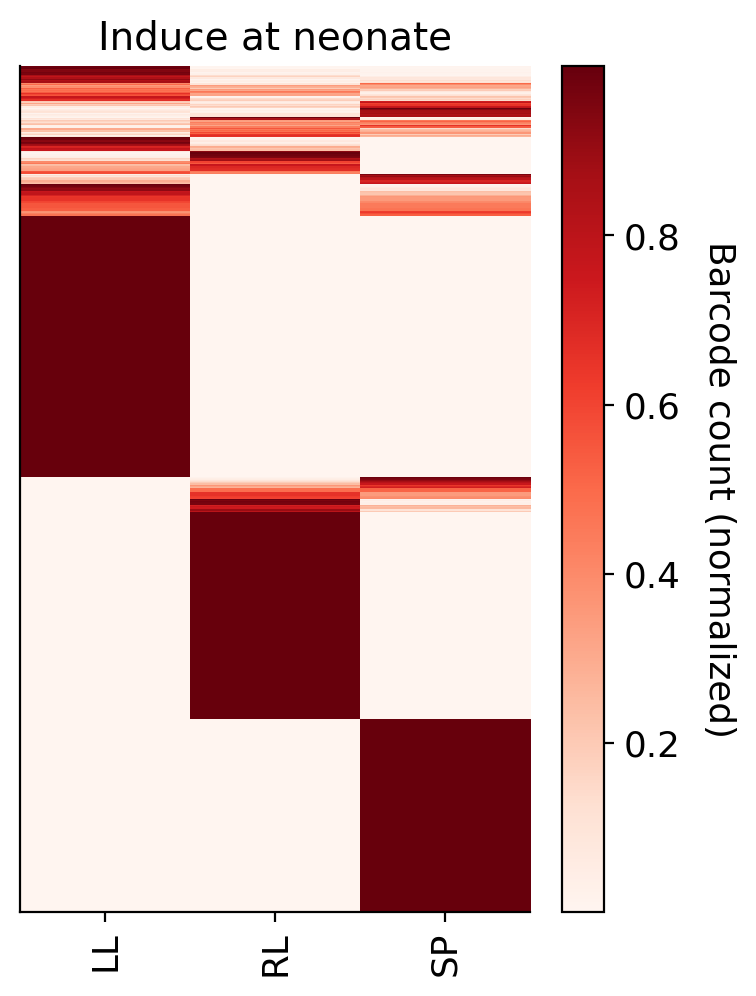

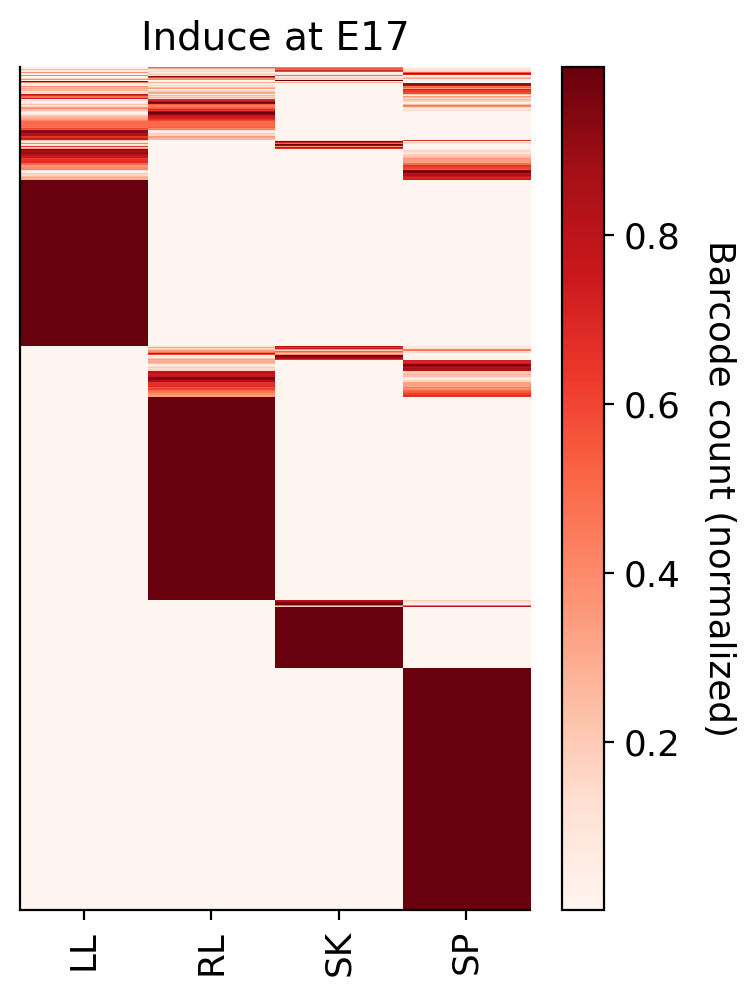

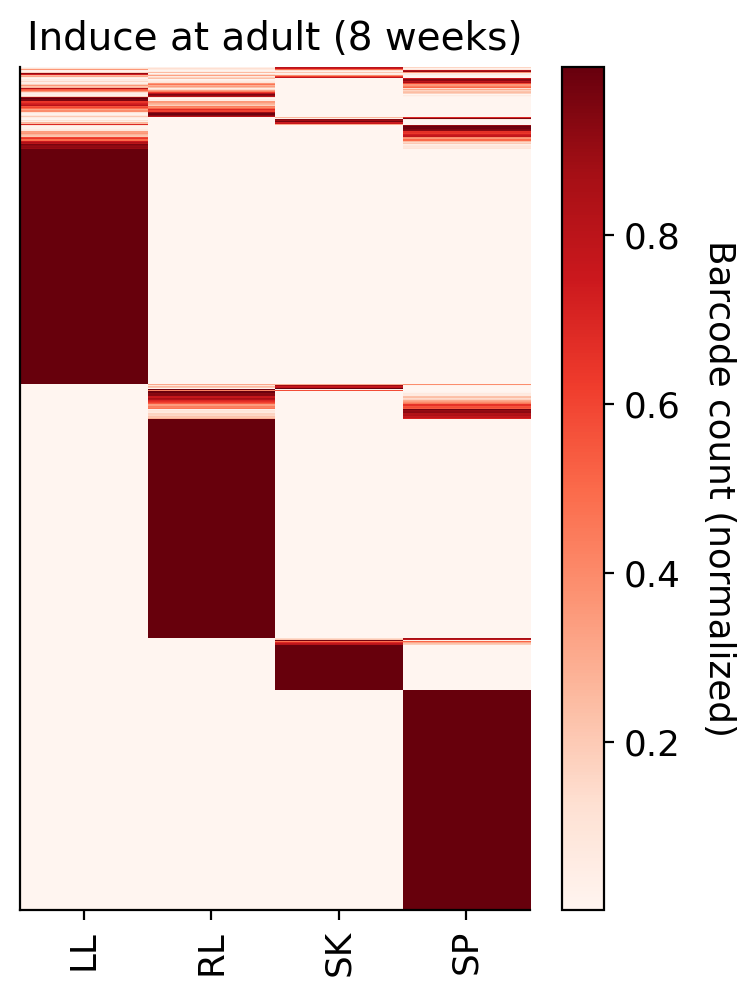

In [22]:
for mouse in mouse_list:    
    if map_mouse_to_SampleList[mouse]=='with_skull':
        SampleList_RAW_1=[rename_LF(x).split('_')[0] for x in SampleList_RAW_0 if mouse in x]
        if mouse=='LL789': SampleList_RAW_1.remove('LL789-LL-Meg')
        SampleList_RAW_2=[SampleList_RAW_1[:4],SampleList_RAW_1[4:8],SampleList_RAW_1[8:12],SampleList_RAW_1[12:16]]
    else:

        SampleList_RAW_1=[rename_LF(x).split('_')[0] for x in SampleList_RAW_noSkull_0 if mouse in x]
        if mouse=='LL789': SampleList_RAW_1.remove('LL789-LL-Meg')
        SampleList_RAW_2=[SampleList_RAW_1[:4],SampleList_RAW_1[4:8],SampleList_RAW_1[8:12]]

    
    short_names=[x[6:8] for x in hf.extract_first_sample_from_a_nesting_list(SampleList_RAW_2)]
    
    df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity}_freq{frequency_cutoff}.csv')
    
    adata_orig = hf.generate_adata_cell_by_allele(df_sc_CARLIN_HQ, min_clone_size=min_clone_size,clone_id_key='allele')
    cs.settings.set_figure_params(figsize=(4,4))
    
    mosaic_pl.analyze_cell_coupling_core(
        adata_orig,
        selected_fates=SampleList_RAW_2,
        short_names=short_names,
        remove_single_lineage_clone=False,
        plot_sample_number=False,
        plot_barcodes_binary=False,
        plot_barcodes_normalize=True,
        plot_restricted=False,
        plot_cell_count=False,
        plot_hierarchy=False,
        plot_Jaccard=False,
        plot_pie=False,
        plot_correlation=False,
        order_map=False,
        included_fates_N=[0],
        included_fates_mode="only",
        time_info=None,
        print_matrix=False,
        figure_path=paper_figure_path,
        data_des=f"{mouse}",
        vmax=0.25,
    )
    plt.title(f'{mouse_map_2[mouse]}')
    plt.tight_layout()
    plt.savefig(f"{paper_figure_path}/all_barcode_heatmap_tissue_{mouse_map[mouse]}.pdf")

100%|██████████████████████████████████████████████████████████████| 68174/68174 [00:00<00:00, 638941.92it/s]


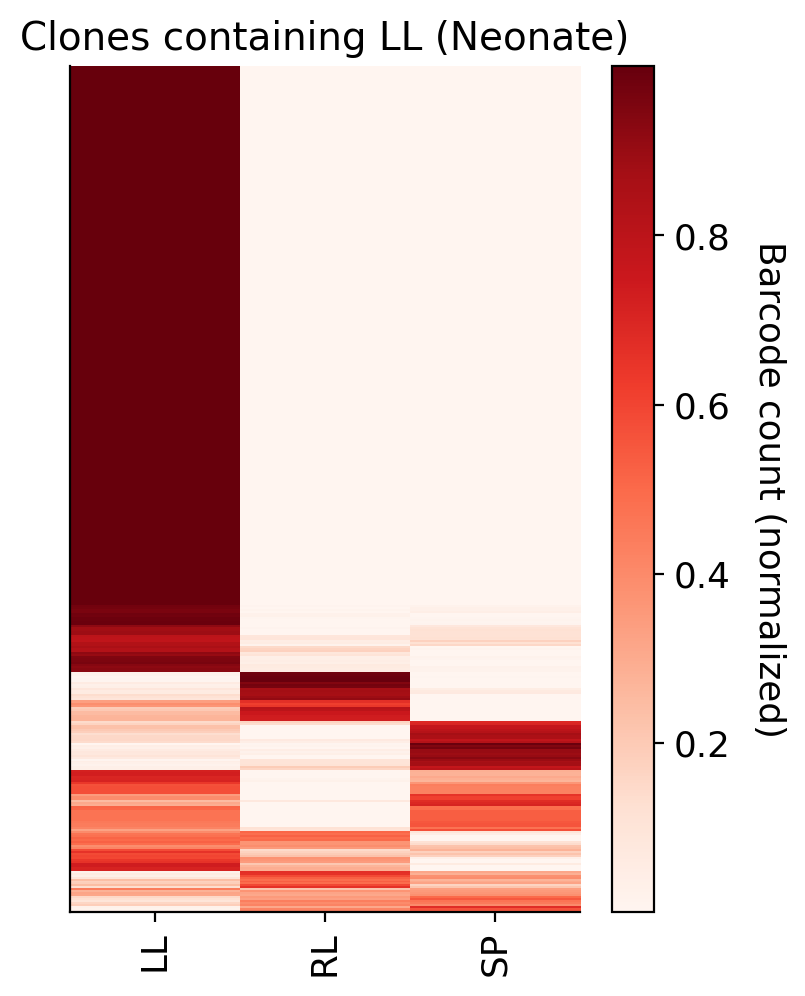

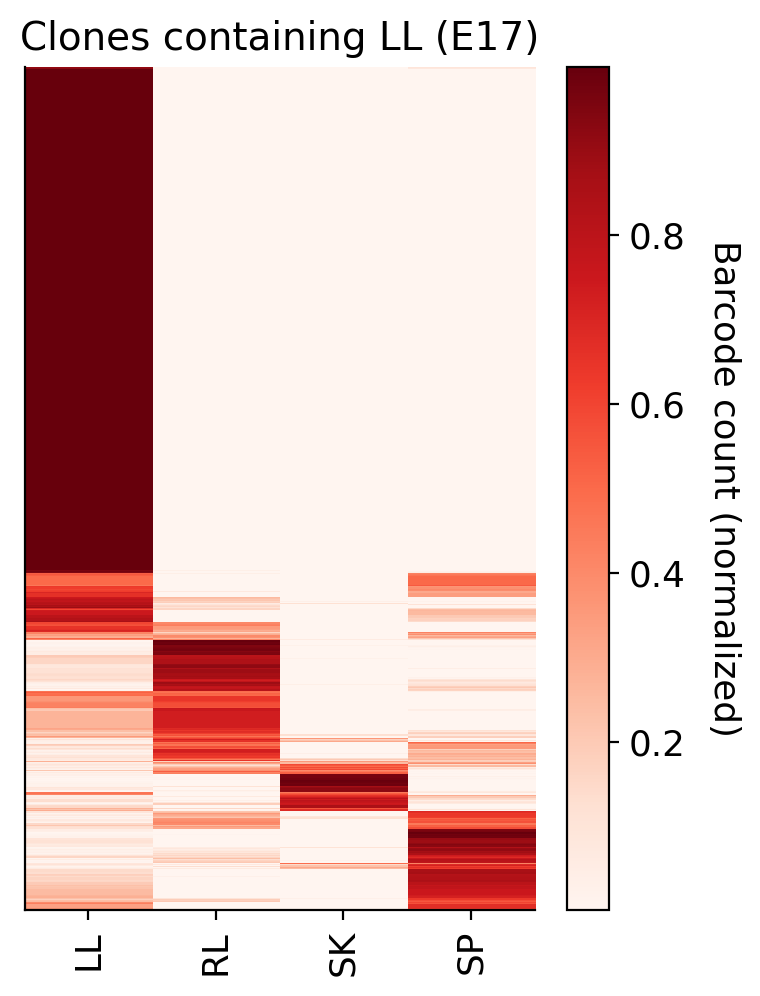

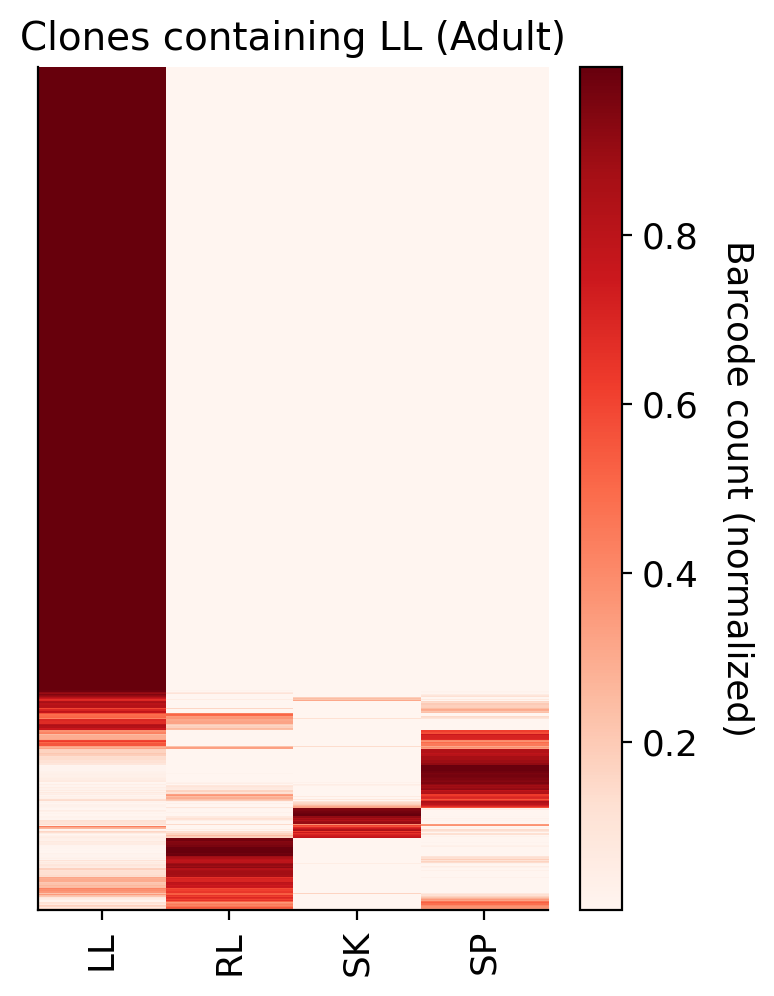

In [10]:
for mouse in mouse_list:
    if map_mouse_to_SampleList[mouse]=='with_skull':
        SampleList_RAW_1=[rename_LF(x).split('_')[0] for x in SampleList_RAW_0 if mouse in x]
        if mouse=='LL789': SampleList_RAW_1.remove('LL789-LL-MkP')
        SampleList_RAW_2=[SampleList_RAW_1[:4],SampleList_RAW_1[4:8],SampleList_RAW_1[8:12],SampleList_RAW_1[12:16]]
    else:

        SampleList_RAW_1=[rename_LF(x).split('_')[0] for x in SampleList_RAW_noSkull_0 if mouse in x]
        if mouse=='LL789': SampleList_RAW_1.remove('LL789-LL-MkP')
        SampleList_RAW_2=[SampleList_RAW_1[:4],SampleList_RAW_1[4:8],SampleList_RAW_1[8:12]]
    
    short_names=[x[6:8] for x in hf.extract_first_sample_from_a_nesting_list(SampleList_RAW_2)]
    
    df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity}_freq{frequency_cutoff}.csv')
    
    adata_orig = hf.generate_adata_cell_by_allele(df_sc_CARLIN_HQ, min_clone_size=min_clone_size,clone_id_key='allele')
    cs.settings.set_figure_params(figsize=(4,4))
    
    mosaic_pl.analyze_cell_coupling_core(
        adata_orig,
        selected_fates=SampleList_RAW_2,
        short_names=short_names,
        remove_single_lineage_clone=False,
        plot_sample_number=False,
        plot_barcodes_binary=False,
        plot_barcodes_normalize=False,
        plot_restricted=True,
        plot_cell_count=False,
        plot_hierarchy=False,
        plot_Jaccard=False,
        plot_pie=False,
        plot_correlation=False,
        order_map=False,
        included_fates_N=[0],
        included_fates_mode="only",
        time_info=None,
        print_matrix=False,
        figure_path=paper_figure_path,
        data_des=f"{mouse}",
        vmax=0.25,
    )
    plt.title(f'Clones containing {short_names[0]} ({mouse_map[mouse]})')
    plt.tight_layout()
    plt.savefig(f"{paper_figure_path}/restricted_barcode_heatmap_tissue_{mouse_map[mouse]}.pdf")

## Clonal overlap analysis between different bones

In [12]:
data_des='distinguish_ref_type'

for mouse in mouse_list:
    df_all_list=[]
    for BC_complexity_tmp in [2,4,6]: 
        df_sc_CARLIN_HQ=pd.read_csv(f'{data_path_1}/merge_all/df_allele_all_{mouse}_{save_data_des}_HQ_BCcomplex{BC_complexity_tmp}_freq{frequency_cutoff}.csv')
    
        df_clone=df_sc_CARLIN_HQ.groupby(['allele','sample']).agg(count=('RNA_id',lambda x: len(set(x)))).reset_index()
        df_clone['tissue']=df_clone['sample'].apply(lambda x: x[6:]) 
        df_tmp=df_clone.groupby('allele').agg({'count':'sum'})
        df_clone_HQ=df_clone[df_clone['allele'].isin(df_tmp[df_tmp['count']>=min_clone_size].index)] 
    
        HQ_clone_N=len(df_sc_CARLIN_HQ['allele'].unique())
        twoCell_Clone_N=len(df_clone_HQ['allele'].unique())
        print(f'HQ clone Num: {HQ_clone_N};  HQ clone with >1 cells: {twoCell_Clone_N}')
    
        df_table=df_clone_HQ.pivot(index='tissue',columns='allele',values='count').fillna(0).T
        df_tmp_count=(df_table.T.to_numpy()>0).astype(int)
        share_N_matrix=np.dot(df_tmp_count,df_tmp_count.T)
        all_fates=list(df_table.columns)
    
        celltype_list=list(set([x.split('-')[1] for x in all_fates]))
        tissue_list=list(set([x.split('-')[0] for x in all_fates]))
        for tissue in tissue_list:
            tissue_list_tmp=tissue_list.copy()
            tissue_list_tmp.remove(tissue)
            df_list=[]
            for celltype in celltype_list:
                target_id=f'{tissue}-{celltype}'
                if data_des != 'distinguish_ref_type':
                    print('Do not distinguish ref type')
                    reference_id_list=[list(np.array([[f'{y}-{z}' for y in tissue_list_tmp] for z in celltype_list]).flatten())]
                else:
                    print('distinguish ref type')
                    reference_id_list=[[f'{y}-{celltype}' for y in tissue_list_tmp]]
    
                print(f'----- target_id: {target_id}')
                print(f'----- reference ids: {reference_id_list}')
                df=mosaic_pl.bar_plot_for_inverse_overlap(df_table,target_id=target_id,
                                            reference_id_list=reference_id_list,tissue_color_map=None,plot=False)
                df['target_id']=target_id
                df_list.append(df)
            df_all=pd.concat(df_list,ignore_index=True)
            df_all['tissue']=tissue
            df_all['mouse']=mouse
            df_all['allele_complexity']=BC_complexity_tmp
            df_all['read_cutoff']=read_cutoff
            df_all['min_clone_size']=min_clone_size
            df_all_list.append(df_all)

    df_final=pd.concat(df_all_list)
    df_final['overlap_fraction']=100*df_final['overlap_fraction']
    df_final['target_cell_type']=df_final['target_id'].apply(lambda x: x.split('-')[1])
    df_final['ref_N']=df_final['ref_cell_type'].apply(lambda x:len(x.split('_')))
    df_final['celltype_id']=df_final['target_cell_type'].map({'HSC':0,'MPP':1,'MkP':2,'MyP':3})
    df_final['stage']=df_final['mouse'].map(mouse_map)
    df_final['stage_id']=df_final['stage'].map(stage_id_map)
    df_final.to_csv(f'{data_analysis_path}/overlapping_across_tissue_{mouse}_{data_des}_all_info_{save_data_des}.csv',index=0)

HQ clone Num: 1498;  HQ clone with >1 cells: 980
distinguish ref type
----- target_id: LL-MPP
----- reference ids: [['SP-MPP', 'RL-MPP']]
distinguish ref type
----- target_id: LL-MkP
----- reference ids: [['SP-MkP', 'RL-MkP']]
distinguish ref type
----- target_id: LL-MyP
----- reference ids: [['SP-MyP', 'RL-MyP']]
distinguish ref type
----- target_id: LL-HSC
----- reference ids: [['SP-HSC', 'RL-HSC']]
distinguish ref type
----- target_id: SP-MPP
----- reference ids: [['LL-MPP', 'RL-MPP']]
distinguish ref type
----- target_id: SP-MkP
----- reference ids: [['LL-MkP', 'RL-MkP']]
distinguish ref type
----- target_id: SP-MyP
----- reference ids: [['LL-MyP', 'RL-MyP']]
distinguish ref type
----- target_id: SP-HSC
----- reference ids: [['LL-HSC', 'RL-HSC']]
distinguish ref type
----- target_id: RL-MPP
----- reference ids: [['LL-MPP', 'SP-MPP']]
distinguish ref type
----- target_id: RL-MkP
----- reference ids: [['LL-MkP', 'SP-MkP']]
distinguish ref type
----- target_id: RL-MyP
----- reference 

In [13]:
# Merge the overlap analysis results

data_des='distinguish_ref_type'
df_list=[]
for mouse in mouse_list:
    df_tmp=pd.read_csv(f'{data_analysis_path}/overlapping_across_tissue_{mouse}_{data_des}_all_info_{save_data_des}.csv')
    df_list.append(df_tmp)
    
df_final=pd.concat(df_list)

Neonate


,celltype_id,overlap_fraction
0,0,11.273098
1,1,28.360997
2,2,24.125312
3,3,45.381271


E17


,celltype_id,overlap_fraction
0,0,12.898653
1,1,23.606637
2,2,19.956985
3,3,41.392826


Adult


,celltype_id,overlap_fraction
0,0,5.282811
1,1,13.614851
2,2,10.821263
3,3,37.130160


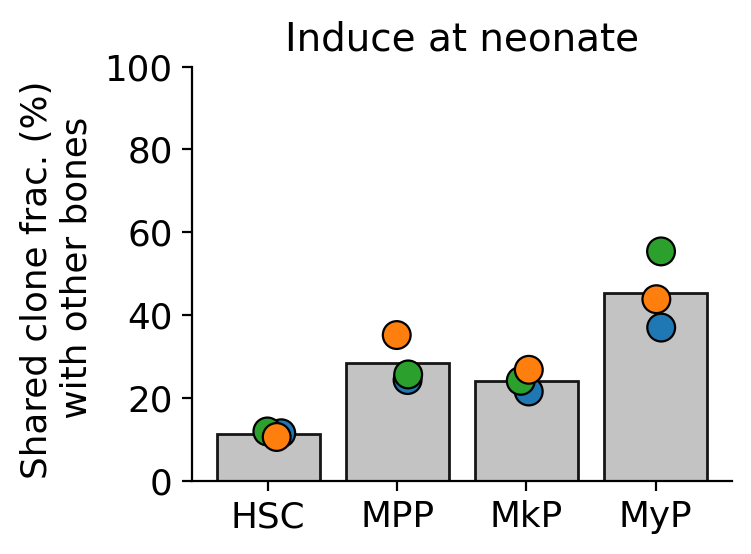

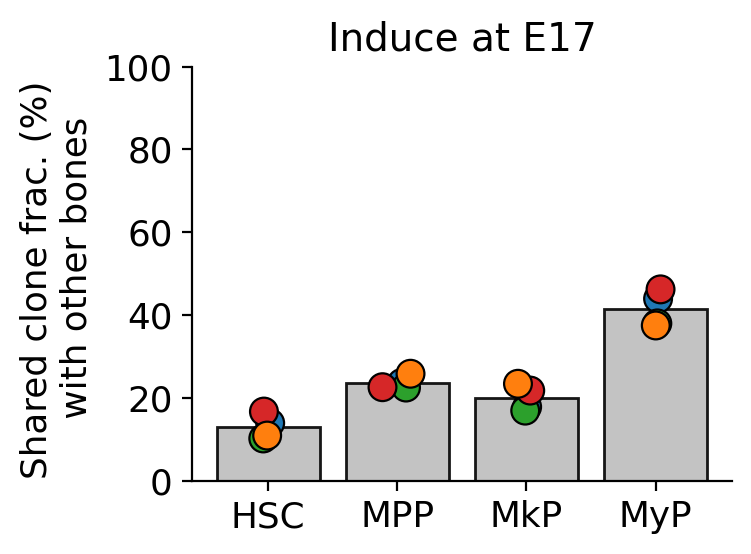

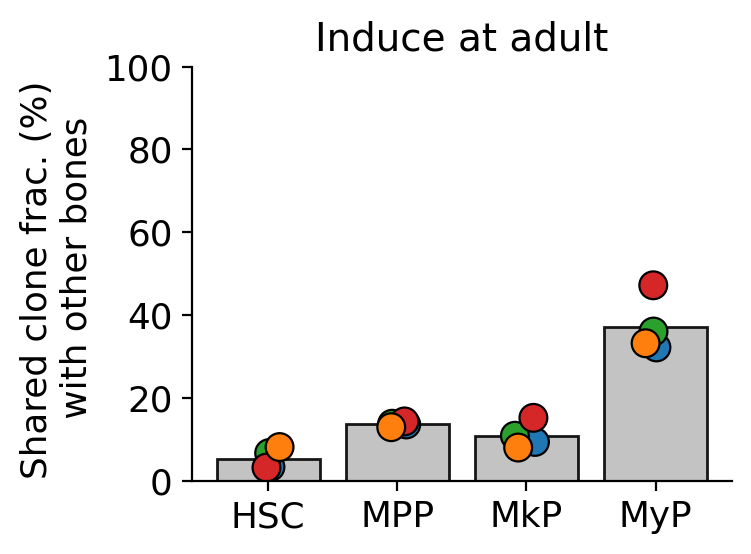

In [15]:
# Shared clone fraction for each cell type across tissues

cs.settings.set_figure_params(figsize=(6,5.5))

df_pvalue_list=[]
for x in df_final['stage'].unique():
    df_tmp=df_final[(df_final['stage']==x)  & (df_final['min_clone_size']==min_clone_size)  & (df_final['allele_complexity']==4)  & (df_final['read_cutoff']==read_cutoff)] 
    
    fig,ax=plt.subplots(figsize=(4,3))
    
    key_1='target_cell_type'
    key_2='overlap_fraction'
    df_pvalue_tmp=pvalue_estimation(df_tmp,key_1,key_2)
    df_pvalue_tmp['variable']=x
    df_pvalue_list.append(df_pvalue_tmp)
        
    key_1='celltype_id'
    df_tmp_1=df_tmp.groupby([key_1]).agg({key_2:'mean'}).reset_index()
    kwargs = {'alpha':0.9, 'linewidth':1, 'edgecolor':'k'}
    ax=sns.barplot(data=df_tmp_1,x=key_1,y=key_2,color='#bdbdbd',**kwargs)
    
    ax=sns.scatterplot(data=df_tmp,x=cs.pl.rand_jitter(df_tmp[key_1],0.03),y=key_2,hue='tissue',s= 100, alpha= 1,edgecolor='k',palette=tissue_colors)
    ax.set_xticks([0,1,2,3], ['HSC','MPP','MkP','MyP'], rotation=0)
    
    print(x)
    display(df_tmp_1)
    
    ax.get_legend().remove()
    plt.ylim([0,100])
    plt.ylabel('Shared clone frac. (%) \n with other bones')
    plt.xlabel('')
    
    plt.title(title_map[x])
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/max_overlap_with_other_bones_over_celltype_{data_des}_{x}.pdf')
    
df_pvalue=pd.concat(df_pvalue_list,ignore_index=True)

## Robustness test
(using only one value here as example. To reproduce the paper result, go to the above code and run with all parameters)

target clone N: 132.80555555555557
target clone N: 439.0625
target clone N: 259.5833333333333


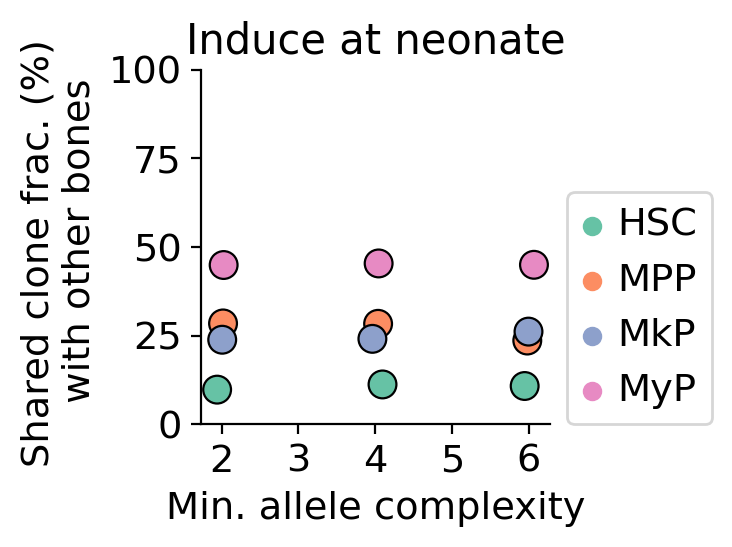

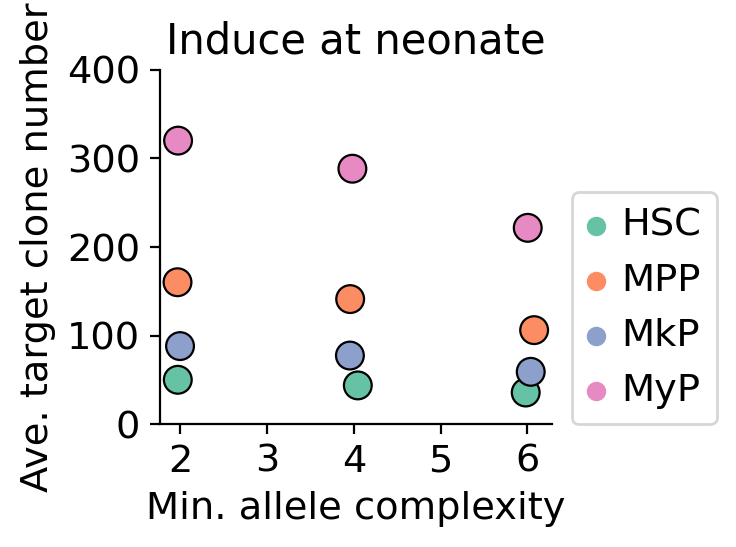

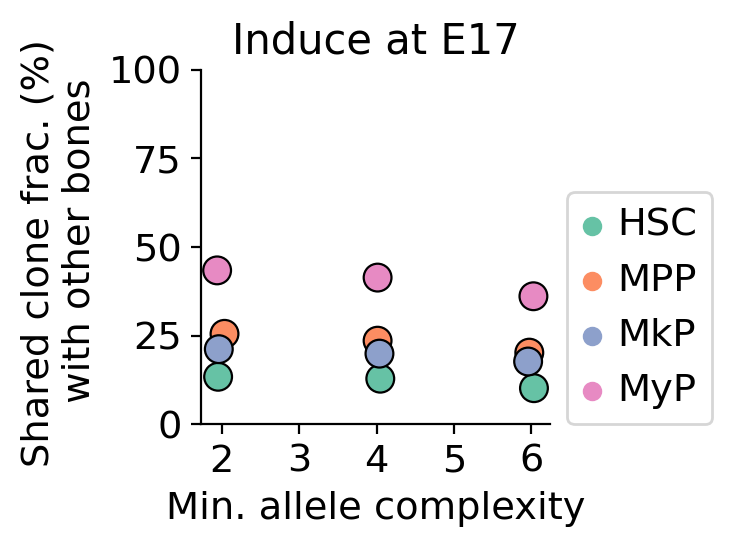

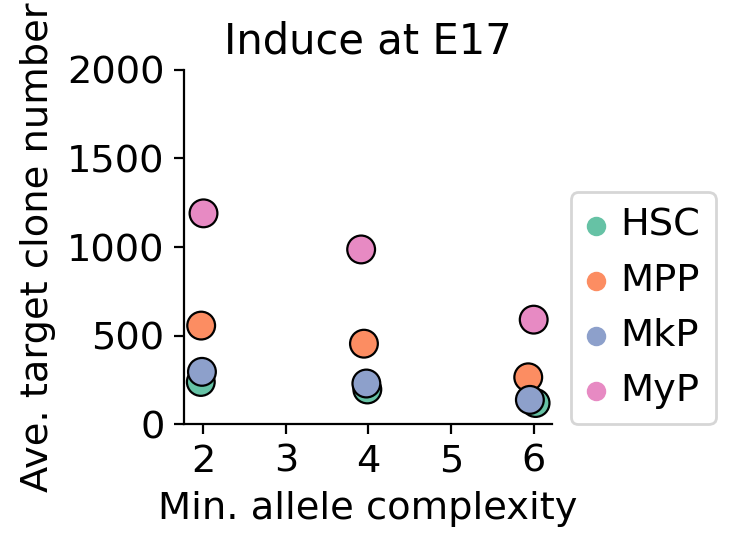

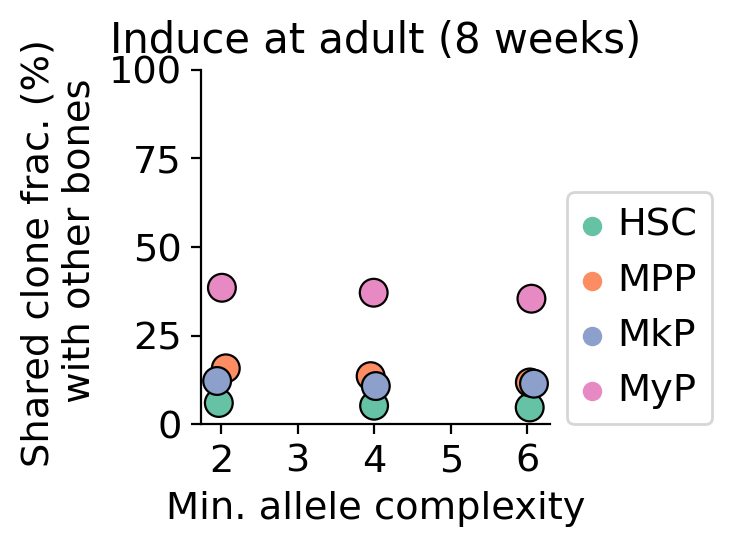

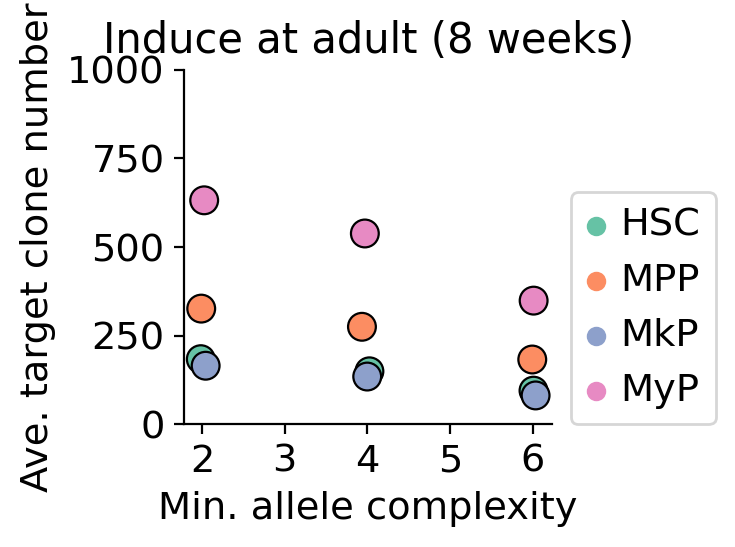

In [21]:
# Shared clone fraction (or average target clone number) for each allele complexity across cell types

cs.settings.set_figure_params(figsize=(6,5.5),fontsize=15)

for mouse in mouse_list:
    df_tmp=df_final[(df_final['allele_complexity']<=6) & (df_final['mouse']==mouse)  & (df_final['min_clone_size']==min_clone_size) & (df_final['read_cutoff']==read_cutoff)] 
    df_tmp=df_tmp.groupby(['allele_complexity','target_cell_type']).agg('mean').reset_index()
    
    print('target clone N:',df_tmp['target_clone_N'].mean())
    fig,ax=plt.subplots(figsize=(4,3))
    ax=sns.scatterplot(data=df_tmp,
                      x=cs.pl.rand_jitter(df_tmp['allele_complexity'],0.01),y='overlap_fraction',
                       hue='target_cell_type',s=100, alpha= 1,edgecolor='k',palette=celltype_colors)
    ax.get_legend().remove()
    plt.legend(loc=[1.05,0])
    plt.ylim([0,100]) 
    plt.xticks([2,3,4,5,6],[2,3,4,5,6])
    plt.ylabel('Shared clone frac. (%) \n with other bones')
    plt.xlabel('Min. allele complexity')
    plt.title(mouse_map_2[mouse])
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/max_overlap_with_other_bones_over_mutation_num_{mouse_map[mouse]}.pdf')

    fig,ax=plt.subplots(figsize=(4,3))
    ax=sns.scatterplot(data=df_tmp,
                       x=cs.pl.rand_jitter(df_tmp['allele_complexity'],0.01),y='target_clone_N',hue='target_cell_type',s=100, 
                       alpha= 1,edgecolor='k',palette=celltype_colors)
    ax.get_legend().remove()
    plt.legend(loc=[1.05,0])
    plt.xticks([2,3,4,5,6],[2,3,4,5,6])
    plt.ylim([0,ylim_map[mouse]])
    plt.ylabel('Ave. target clone number')
    plt.xlabel('Min. allele complexity')
    plt.title(mouse_map_2[mouse])
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/target_clone_N_with_other_bones_over_mutation_num_{data_des}_{mouse_map[mouse]}.pdf')

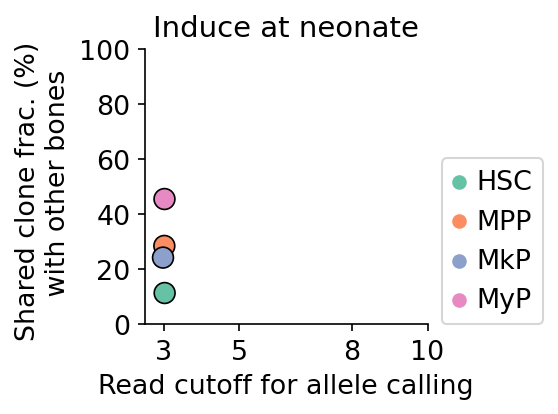

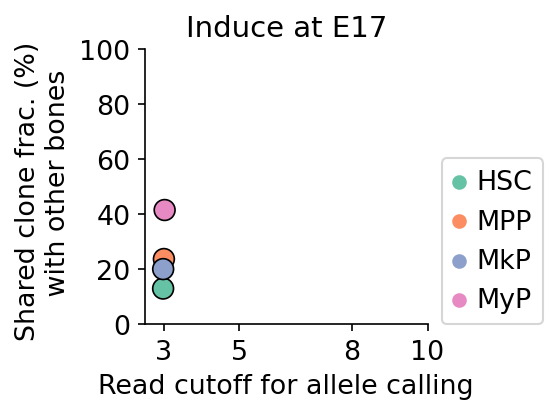

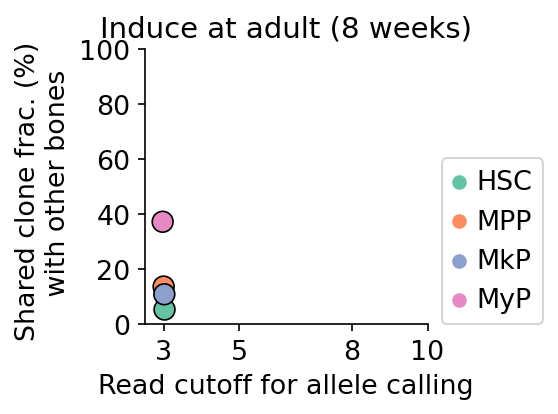

In [20]:
# Shared clone fraction for each read cutoff across cell types

data_des='distinguish_ref_type'

for mouse in mouse_list:
    fig,ax=plt.subplots(figsize=(4,3))
    df_tmp=df_final[(df_final['min_clone_size']==min_clone_size) &  (df_final['mouse']==mouse) & (df_final['allele_complexity']==4)  ]

    key_1='read_cutoff'
    key_2='overlap_fraction'
    df_tmp=df_tmp.groupby([key_1,'target_cell_type']).agg('mean').reset_index()
        

    ax=sns.scatterplot(data=df_tmp,x=cs.pl.rand_jitter(df_tmp[key_1],0.01),hue='target_cell_type',y=key_2,s=100, alpha= 1,edgecolor='k',palette=celltype_colors)
    ax.set_xticks([3,5,8,10], [3,5,8,10], rotation=0)  
    ax.set_xlim([2.5,10])

    #ax.get_legend().remove()
    plt.legend(loc=[1.05,0])

    plt.ylim([0,100])

    plt.ylabel('Shared clone frac. (%) \n with other bones')
    plt.xlabel('Read cutoff for allele calling')
    plt.title(mouse_map_2[mouse])
    plt.tight_layout()
    plt.savefig(f'{paper_figure_path}/max_overlap_with_other_bones_over_readcutoff_{data_des}_{mouse_map[mouse]}.pdf')